In [9]:
! pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


4096


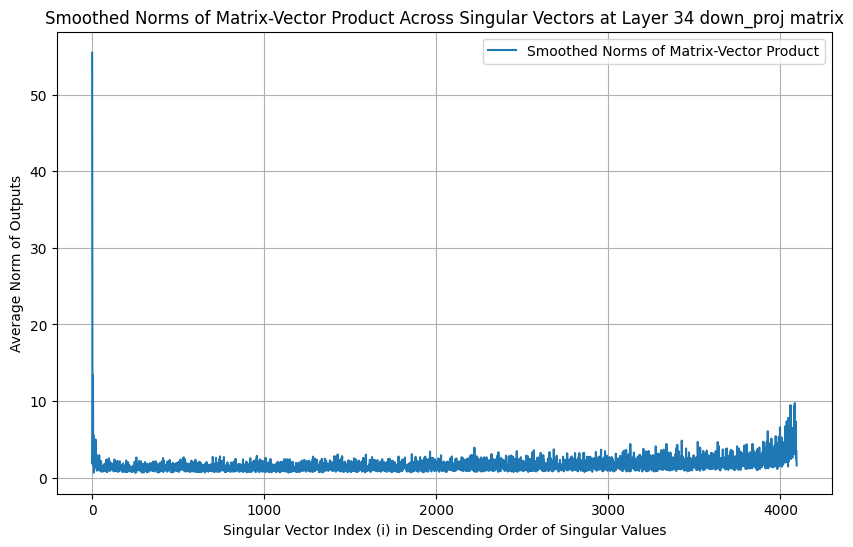

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Path to your norm_logs.jsonl file
file_path = '../norm_logs.jsonl'  # Replace with the actual file path

# Load the data from the JSONL file
data = []
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line.strip()))

# Convert the data to a numpy array
data_array = np.array(data)

# Calculate the averages for each entry across all lines
averages = np.mean(data_array, axis=0)

print(len(averages))

# Smooth the data using a moving average
window_size = 10  # Adjust the window size as needed
smoothed_averages = np.convolve(averages, np.ones(window_size)/window_size, mode='valid')

# Plot the smoothed averages
plt.figure(figsize=(10, 6))
plt.plot(averages, label="Smoothed Norms of Matrix-Vector Product")
plt.title('Smoothed Norms of Matrix-Vector Product Across Singular Vectors at Layer 34 down_proj matrix')
plt.xlabel('Singular Vector Index (i) in Descending Order of Singular Values')
plt.ylabel('Average Norm of Outputs')
plt.grid(True)
plt.legend()
plt.show()


In [5]:
averages[-20:]

array([4.41847535, 6.13320288, 6.45810513, 6.50761126, 4.39303102,
       9.3096038 , 5.96649791, 4.96830735, 9.73421968, 4.8531875 ,
       3.76090482, 3.02125127, 3.41223343, 7.05718773, 7.33203338,
       2.52699725, 3.57648544, 2.8442103 , 2.08571306, 1.59224675])

In [1]:
import os, json
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, PreTrainedModel, GraniteForCausalLM

/home/lab/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
model = AutoModelForCausalLM.from_pretrained("/new_data/experiments/ap-8b-p10-rhel13-data-id-2/hf_format/samples_10597250")

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


In [20]:
for name, module in model.named_children():
    print(f"Layer Name: {name}")
    print(module)

Layer Name: model
GraniteModel(
  (embed_tokens): Embedding(49160, 4096, padding_idx=49152)
  (layers): ModuleList(
    (0-39): 40 x GraniteDecoderLayer(
      (self_attn): GraniteSdpaAttention(
        (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
      )
      (mlp): GraniteMLP(
        (gate_proj): Linear(in_features=4096, out_features=12800, bias=False)
        (up_proj): Linear(in_features=4096, out_features=12800, bias=False)
        (down_proj): Linear(in_features=12800, out_features=4096, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): GraniteRMSNorm((4096,), eps=1e-05)
      (post_attention_layernorm): GraniteRMSNorm((4096,), eps=1e-05)
    )
  )
  (norm): GraniteRMSNorm((4096,), eps=1e-05)
  (rotary_emb): GraniteRota

In [ ]:
import torch
import numpy as np
import csv

def compute_effective_rank(matrix, sigma_threshold):
    """
    Compute the effective rank of the matrix based on the given threshold.
    """
    U, S, Vh = torch.linalg.svd(matrix, full_matrices=False)
    effective_rank = (S > sigma_threshold).sum().item()
    return effective_rank

def compute_threshold(matrix):
    """
    Compute the noise threshold based on the formula in the image.
    """
    matrix = matrix.T if matrix.shape[0] > matrix.shape[1] else matrix
    m, n = matrix.shape
    sigma = matrix.std().item()
    epsilon_minus = sigma * (1 - np.sqrt(m / n))
    print(epsilon_minus)
    return epsilon_minus

def analyze_layers(granite_model):
    """
    Analyze each matrix in the GraniteForCausalLM model and compute its rank and effective rank.
    """
    results = []
    layers = granite_model.model.layers  # Accessing the layers from model.model.layers

    for layer_num, layer in enumerate(layers):
        # Handle self-attention matrices
        for name, module in layer.self_attn.named_children():
            if isinstance(module, torch.nn.Linear):
                matrix = module.weight.data
                rank = min(matrix.shape)
                threshold = compute_threshold(matrix)
                effective_rank = compute_effective_rank(matrix, threshold)
                results.append([layer_num, f"self_attn.{name}", rank, effective_rank])
                print('Done!')

        # Handle MLP matrices
        for name, module in layer.mlp.named_children():
            if isinstance(module, torch.nn.Linear):
                matrix = module.weight.data
                rank = min(matrix.shape)
                threshold = compute_threshold(matrix)
                effective_rank = compute_effective_rank(matrix, threshold)
                results.append([layer_num, f"mlp.{name}", rank, effective_rank])
                print('Done!')
    
    return results

# Assuming 'granite_model' is your GraniteForCausalLM instance
granite_model = AutoModelForCausalLM.from_pretrained("/new_data/experiments/ap-8b-p10-rhel13-data-id-2/hf_format/samples_10597250")  # Replace with your model initialization
results = analyze_layers(granite_model)

# Save the results to a CSV file
output_file = 'layer_analysis_results.csv'
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Layer Number", "Layer Name", "Rank", "Effective Rank"])
    writer.writerows(results)

print(f"Results saved to {output_file}")

Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


0.0
Done!
0.006943142972886562
Done!
0.005263003055006266
Done!
0.0
Done!
0.0044810902711277965
Done!
0.005805927471491581
Done!
0.005654025626468812
Done!
0.0
Done!
0.007992480881512165
Done!
0.004703180864453316
Done!
0.0
Done!
0.004464950836608478
Done!
0.005734539970955759
Done!
0.005526376011087135
Done!
0.0
Done!
0.008300664834678173
Done!
0.004729898180812597
Done!
0.0
Done!
0.004874703820677159
Done!
0.00540808501068938
Done!
0.005295176518377852
Done!
0.0
Done!
0.007821341045200825
Done!
0.004817616194486618
Done!
0.0
Done!
0.005020234591463348
Done!
0.0052185432263510655
Done!
0.0051631847353922344
Done!
0.0
Done!
0.007689760997891426
Done!
0.004994333256036043
Done!
0.0
Done!
0.005028936319610865
Done!
0.005223960924803529
Done!
0.005168394932029996
Done!
0.0
Done!
0.007572722155600786
Done!
0.004832604434341192
Done!
0.0
Done!
0.0049396959777583075
Done!
0.005290686713030507
Done!
0.005204199309483718
Done!
0.0
Done!
0.0070822048000991344
Done!
0.005234880372881889
Done!
0.

In [ ]:
import torch
import numpy as np
import csv

def compute_singular_value_stats(matrix):
    """
    Compute the min, max, mean, and median singular values of the given matrix.
    """
    _, S, _ = torch.linalg.svd(matrix, full_matrices=False)
    singular_values = S.cpu().numpy()
    min_sv = np.min(singular_values)
    max_sv = np.max(singular_values)
    mean_sv = np.mean(singular_values)
    median_sv = np.median(singular_values)
    return min_sv, max_sv, mean_sv, median_sv

def analyze_layers(granite_model):
    """
    Analyze each matrix in the GraniteForCausalLM model and compute singular value statistics.
    """
    results = []
    layers = granite_model.model.layers  # Accessing the layers from model.model.layers

    for layer_num, layer in enumerate(layers):
        # Handle self-attention matrices
        for name, module in layer.self_attn.named_children():
            if isinstance(module, torch.nn.Linear):
                matrix = module.weight.data
                min_sv, max_sv, mean_sv, median_sv = compute_singular_value_stats(matrix)
                results.append([layer_num, f"self_attn.{name}", min_sv, max_sv, mean_sv, median_sv])
                print(f'Done processing layer {layer_num}, self_attn.{name}!')

        # Handle MLP matrices
        for name, module in layer.mlp.named_children():
            if isinstance(module, torch.nn.Linear):
                matrix = module.weight.data
                min_sv, max_sv, mean_sv, median_sv = compute_singular_value_stats(matrix)
                results.append([layer_num, f"mlp.{name}", min_sv, max_sv, mean_sv, median_sv])
                print(f'Done processing layer {layer_num}, mlp.{name}!')
    
    return results

# Assuming 'granite_model' is your GraniteForCausalLM instance
granite_model = AutoModelForCausalLM.from_pretrained("/new_data/experiments/ap-8b-p10-rhel13-data-id-2/hf_format/samples_10597250")  # Replace with your model initialization
results = analyze_layers(granite_model)

# Save the results to a CSV file
output_file = 'layer_singular_value_stats.csv'
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Layer Number", "Layer Name", "Min Singular Value", "Max Singular Value", "Mean Singular Value", "Median Singular Value"])
    writer.writerows(results)

print(f"Results saved to {output_file}")

Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]


Done processing layer 0, self_attn.q_proj!
Done processing layer 0, self_attn.k_proj!
Done processing layer 0, self_attn.v_proj!
Done processing layer 0, self_attn.o_proj!
Done processing layer 0, mlp.gate_proj!
Done processing layer 0, mlp.up_proj!
Done processing layer 0, mlp.down_proj!
Done processing layer 1, self_attn.q_proj!
Done processing layer 1, self_attn.k_proj!
Done processing layer 1, self_attn.v_proj!
Done processing layer 1, self_attn.o_proj!
Done processing layer 1, mlp.gate_proj!
Done processing layer 1, mlp.up_proj!
Done processing layer 1, mlp.down_proj!
Done processing layer 2, self_attn.q_proj!
Done processing layer 2, self_attn.k_proj!
Done processing layer 2, self_attn.v_proj!
Done processing layer 2, self_attn.o_proj!
Done processing layer 2, mlp.gate_proj!
Done processing layer 2, mlp.up_proj!
Done processing layer 2, mlp.down_proj!
Done processing layer 3, self_attn.q_proj!
Done processing layer 3, self_attn.k_proj!
Done processing layer 3, self_attn.v_proj!
D

In [11]:
# Function to save singular value statistics plots for each type of layer
def save_singular_value_stats(data, layer_type):
    """
    Save the singular value statistics (min, max, mean, median) plot for a specific layer type.
    """
    # Filter the data for the given layer type
    layer_data = data[data['Layer Name'].str.contains(layer_type)]

    # Create a figure for the plots
    plt.figure(figsize=(12, 8))

    # Plot each statistic
    plt.plot(layer_data['Layer Number'], layer_data['Min Singular Value'], label='Min Singular Value', marker='o')
    plt.plot(layer_data['Layer Number'], layer_data['Max Singular Value'], label='Max Singular Value', marker='o')
    plt.plot(layer_data['Layer Number'], layer_data['Mean Singular Value'], label='Mean Singular Value', marker='o')
    plt.plot(layer_data['Layer Number'], layer_data['Median Singular Value'], label='Median Singular Value', marker='o')

    # Add plot details
    plt.title(f'Singular Value Statistics for {layer_type}', fontsize=16)
    plt.xlabel('Layer Number', fontsize=14)
    plt.ylabel('Singular Value', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Save the plot
    filename = f'{layer_type}_singular_value_stats.png'
    plt.savefig(filename)
    plt.close()
    print(f"Saved plot for {layer_type} as {filename}")

# Save plots for different layer types
layer_types = ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']
for layer_type in layer_types:
    save_singular_value_stats(data, layer_type)

# Save the heatmap
def save_heatmap(data):
    """
    Save a heatmap showing mean singular values for all layers and layer names.
    """
    pivot_table = data.pivot(index='Layer Number', columns='Layer Name', values='Mean Singular Value')
    plt.figure(figsize=(15, 10))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Mean Singular Value'})
    plt.title('Heatmap of Mean Singular Values Across Layers', fontsize=16)
    plt.xlabel('Layer Name', fontsize=14)
    plt.ylabel('Layer Number', fontsize=14)

    # Save the heatmap
    filename = 'heatmap_mean_singular_values.png'
    plt.savefig(filename)
    plt.close()
    print(f"Saved heatmap as {filename}")

# Save the heatmap
save_heatmap(data)

Saved plot for q_proj as q_proj_singular_value_stats.png
Saved plot for k_proj as k_proj_singular_value_stats.png
Saved plot for v_proj as v_proj_singular_value_stats.png
Saved plot for o_proj as o_proj_singular_value_stats.png
Saved plot for gate_proj as gate_proj_singular_value_stats.png
Saved plot for up_proj as up_proj_singular_value_stats.png
Saved plot for down_proj as down_proj_singular_value_stats.png


Saved heatmap as heatmap_mean_singular_values.png
